# Imports and setup

In [1]:
import numpy as np
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt

# mongoDB
import pymongo
from pymongo import MongoClient
client = MongoClient('localhost', 27017, maxPoolSize=200)
records = client.discussions['wiki-conv']

# Getting article data

In [2]:
# sort the records by timestamp in descending order to build the tree

def clean_article_data(df):
    def collapse_user_name(x):
        res = ''
        if 'ip' in x:
            res = x['ip']
        else:
            res = x['text']
        return res
    
    df.sort_values("timestamp", inplace=True, ascending=False)
    df.reset_index()
    df["user"] = df["user"].apply(collapse_user_name)
    return df


def get_article_data(page_id: str, should_clean_data=True):
    # df = pd.read_json(file_path, lines=True, orient='records')
    df = pd.DataFrame(records.find({"pageId": page_id}).sort("timestamp", pymongo.ASCENDING))
    return clean_article_data(df) if should_clean_data else df
    

# input data: all the actions for a discussion page from the wiki conv dataset
# https://github.com/conversationai/wikidetox/tree/master/wikiconv
df_article = get_article_data("687")

# Analyzing article data

[('Lucarosty', 0), ("JustineLolitad'O", 0), ('InternetArchiveBot', 1), ('FrescoBot', 1), ('Vituzzu', 1), ('5.89.253.110', 1), ('DaimonBot', 1), ('Botcrux', 1), ('Epìdosis', 1), ('Niculinux', 1), ('Bramfab', 4), ('Dennis Radaelli', 1), ('Ricce', 1), ('Rrronny', 1), ('79.33.44.169', 1), ('Stonewall', 1), ('ArtAttack', 2), ('80.180.118.97', 1), ('Italo da b', 4), ('Piero Montesacro', 2), ('Theirrulez', 3), ('Riottoso', 0), ('Diko', 1), ('83.103.74.23', 1), ('Marte77', 1), ('78.12.208.55', 1), ('80.64.113.3', 2), ('Solocalzinidicotonescuri', 2), ('93.150.179.76', 1), ('Melquíades', 1), ('No2', 1), ('AlainCh', 2), ('87.12.30.143', 1), ('Zamp', 1), ('79.12.134.111', 1), ('213.156.52.108', 1), ('193.204.206.252', 1), ('Borgolibero', 1), ('Gacio', 1), ('87.15.26.155', 1), ('87.28.141.207', 1), ('Dpianelli', 1), ('Fullo88', 1), ('217.166.34.187', 1), ('217.166.34.127', 1), ('Fioravante Patrone', 1), ('80.182.70.86', 1), ('Ricpen82', 1), ('Ricbale', 2), ('Francomemoria', 1), ('Twice25', 4), ('15

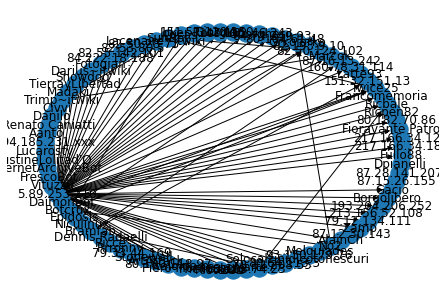

In [3]:
# graph for deletion and modification (dm actions):
# - each node v is a user involved in the article
# - each edge (u,v) implies that user u has done a dm action on user v

G = nx.DiGraph()
G.add_nodes_from(df_article['user'].unique())

for index, record in enumerate(df_article.iloc()):
    if record.parentId and record.type in ['MODIFICATION', 'DELETION']:
        try:
            parent_record = df_article[df_article['id'] == record.parentId].iloc[0]
            if parent_record.user != record.user:
                G.add_edge(record.user, parent_record.user)
        except:
            pass
        
nx.draw_shell(G, with_labels=True)
print(G.in_degree)

[('Lucarosty', 0), ("JustineLolitad'O", 0), ('InternetArchiveBot', 0), ('FrescoBot', 0), ('Vituzzu', 0), ('5.89.253.110', 0), ('DaimonBot', 0), ('Botcrux', 0), ('Epìdosis', 0), ('Niculinux', 1), ('Bramfab', 7), ('Dennis Radaelli', 0), ('Ricce', 0), ('Rrronny', 0), ('79.33.44.169', 0), ('Stonewall', 0), ('ArtAttack', 1), ('80.180.118.97', 0), ('Italo da b', 1), ('Piero Montesacro', 1), ('Theirrulez', 0), ('Riottoso', 0), ('Diko', 0), ('83.103.74.23', 1), ('Marte77', 3), ('78.12.208.55', 1), ('80.64.113.3', 0), ('Solocalzinidicotonescuri', 0), ('93.150.179.76', 0), ('Melquíades', 0), ('No2', 0), ('AlainCh', 1), ('87.12.30.143', 0), ('Zamp', 0), ('79.12.134.111', 3), ('213.156.52.108', 0), ('193.204.206.252', 0), ('Borgolibero', 1), ('Gacio', 0), ('87.15.26.155', 0), ('87.28.141.207', 0), ('Dpianelli', 0), ('Fullo88', 0), ('217.166.34.187', 1), ('217.166.34.127', 3), ('Fioravante Patrone', 0), ('80.182.70.86', 1), ('Ricpen82', 0), ('Ricbale', 1), ('Francomemoria', 1), ('Twice25', 4), ('15

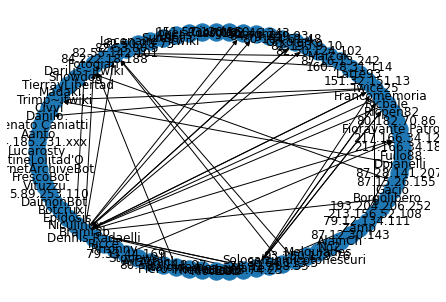

In [4]:
# graph for addition and creation (ac actions):
# - each node v is a user involved in the article
# - each edge (u,v) implies that user u has done a ac action on user v

G = nx.DiGraph()
G.add_nodes_from(df_article['user'].unique())

for index, record in enumerate(df_article.iloc()):
    if record.replytoId and record.type in ['ADDITION', 'CREATION']:
        try:
            parent_record = df_article[df_article['id'] == record.replytoId].iloc[0]
            if parent_record.user != record.user:
                G.add_edge(record.user, parent_record.user)
        except:
            pass
        
nx.draw_shell(G, with_labels=True)
print(G.in_degree)

# Getting number of article with minimum number of actions

In [4]:
df_index = pd.read_json('dataset/wikiconv-it/article_index_it.json', orient='records', lines = True)

<AxesSubplot:xlabel='min_actions'>

<Figure size 432x288 with 0 Axes>

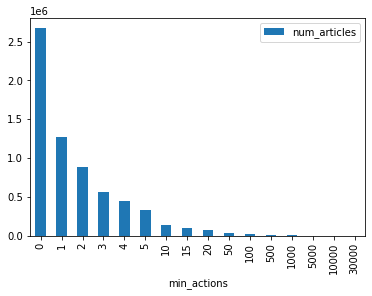

In [6]:
min_actions = np.array([0, 1, 2, 3, 4, 5, 10, 15, 20, 50, 100, 500, 1000, 5000, 10000, 30000])

df_num_actions = pd.DataFrame(data={'min_actions': min_actions})
df_num_actions['num_articles'] = df_num_actions['min_actions'].apply(
    lambda x: len(df_index[df_index['numActions'] > x].index))

plt.figure()
df_num_actions.plot.bar(x='min_actions', y='num_articles')

# Getting stats about type of actions inside each article

In [21]:
"""
import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())

from tqdm import tqdm

actions = {
    'CREATION': np.zeros(num_rows),
    'ADDITION': np.zeros(num_rows),
    'MODIFICATION': np.zeros(num_rows),
    'DELETION': np.zeros(num_rows),
    'RESTORATION': np.zeros(num_rows)
}
client.close()
def process(page_id, index):
    print(ciao)
    clientt = MongoClient('localhost', 27017)
    recordss = clientt.discussions['wiki-conv']
    df = pd.DataFrame(recordss.find({"pageId": str(page_id)}).sort("timestamp", pymongo.ASCENDING))
    print(len(pd.index))
    for action_type in actions.keys():
        print(len(df[df['type'] == action_type].index))
        actions[action_type][index] = len(df[df['type'] == action_type].index)

for index, record in tqdm(df_test.iterrows(), total=num_rows):
    pool.apply_async(process, args=(record['_id'], index))
    
pool.close()
pool.join()
    
print(actions)
"""

100%|██████████| 20/20 [00:00<00:00, 6422.15it/s]

{'CREATION': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), 'ADDITION': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), 'MODIFICATION': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), 'DELETION': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), 'RESTORATION': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])}


In [82]:
df_test = df_index[(df_index['numActions'] > 20)].sample(n = 50)
df_test.reset_index(inplace=True, drop=True)
num_rows = len(df_test.index)
df_test.tail()

,_id,pageTitle,numActions
45,1710365,Discussioni utente:Fale/2007,36
46,2749655,Discussioni utente:Mess/Archivio 7,126
47,58660,Discussione:Samurai,31
48,1182444,Utente:Kensei~itwiki/sandbox2.1,277
49,678822,Utente:Mtt/Bloc-notes,35


In [83]:
from tqdm import tqdm

actions = {
    'CREATION': np.zeros(num_rows),
    'ADDITION': np.zeros(num_rows),
    'MODIFICATION': np.zeros(num_rows),
    'DELETION': np.zeros(num_rows),
    'DM_OTHER_USER': np.zeros(num_rows),
    'DM_OTHER_TOXIC': np.zeros(num_rows),
    'RESTORATION': np.zeros(num_rows)
}

def process(page_id, index):
    df = pd.DataFrame(records.find({"pageId": str(page_id)}).sort("timestamp", pymongo.ASCENDING))
    for action_type in actions.keys():
        if action_type not in ['DELETION_OTHER_USER', 'DELETION_OTHER_TOXIC']:
            actions[action_type][index] = len(df[df['type'] == action_type].index)
        
    df_deletion = df[(df['type'] == 'DELETION') | (df['type'] == 'MODIFICATION')]
    for index2, record2 in df_deletion.iterrows():
        try:
            parent_record = df[df['id'] == record2.parentId].iloc[0]
            if parent_record.user != record2.user:
                actions['DM_OTHER_USER'][index] += 1
                if record2.score['toxicity'] > 0.3:
                    actions['DM_OTHER_TOXIC'][index] += 1
        except:
            pass
    

for index, record in tqdm(df_test.iterrows(), total=num_rows):
    process(record['_id'], index)

100%|██████████| 50/50 [00:07<00:00,  6.26it/s]


In [84]:
actions['DM_OTHER_USER'][0] = 0
actions['DM_OTHER_TOXIC'][0] = 0
process(6055134, 0)

In [85]:
for action_type in actions.keys():
    df_test[action_type] = actions[action_type]
    
df_test

,_id,pageTitle,numActions,CREATION,ADDITION,MODIFICATION,DELETION,DM_OTHER_USER,DM_OTHER_TOXIC,RESTORATION
0,1593355,Discussione:Cleopatra,54,7.0,21.0,9.0,10.0,16.0,7.0,4.0
1,4464007,Discussione:Windows Phone 7,21,10.0,11.0,0.0,0.0,0.0,0.0,0.0
2,3438323,Utente:Alfonso Pompella/Sandbox,24,1.0,4.0,14.0,5.0,6.0,0.0,0.0
3,6777580,Utente:Eleonora.tabarelli79/Sandbox,39,7.0,9.0,8.0,15.0,3.0,0.0,0.0
4,3500204,Utente:Dipralb/Sandbox/9,132,29.0,21.0,33.0,49.0,18.0,0.0,0.0
5,1629109,Utente:Giorgio1993,86,2.0,23.0,44.0,17.0,6.0,0.0,0.0
6,1922289,Utente:History simon,73,2.0,17.0,20.0,22.0,24.0,1.0,12.0
7,4093921,Discussioni utente:TintoMeches,366,86.0,147.0,110.0,23.0,91.0,0.0,0.0
8,2087512,Discussione:Mariacarla Boscono,141,40.0,44.0,20.0,37.0,45.0,0.0,0.0
9,3807804,Discussioni utente:213.149.219.106,25,5.0,6.0,2.0,11.0,12.0,0.0,1.0
